In [6]:
import os
import torch
import random
import librosa
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import soundfile as sf
from tqdm import tqdm
# from pydub import AudioSegment
from scipy.ndimage import label
from torchvision import models
from torchvision import transforms
from PIL import Image
from google.colab import files
from google.cloud import storage

### Import Colab

In [7]:
firts_time = True

In [8]:
if firts_time:
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))


Saving projetos-aleatorios-379913-61df4a1c249e.json to projetos-aleatorios-379913-61df4a1c249e.json
User uploaded file "projetos-aleatorios-379913-61df4a1c249e.json" with length 2372 bytes


In [4]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = f'/content/projetos-aleatorios-379913-61df4a1c249e.json'

In [9]:
storage_client = storage.Client()

In [10]:
bucket_name = 'projeto_musical'
csv_file_name = 'labels.csv'
local_file_path = '/content/' + csv_file_name

# Cria um objeto bucket
bucket = storage_client.get_bucket(bucket_name)

# Cria um objeto blob
blob = bucket.blob(csv_file_name)

# Baixa o arquivo para o ambiente local
blob.download_to_filename(local_file_path)

In [11]:
bucket_name = 'projeto_musical'
rar_file_name = 'variation_chord_audio.rar'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [ ]:
# Descompacta o arquivo RAR
!mkdir /content/
!unrar x {local_rar_path} chords

In [15]:
bucket_name = 'projeto_musical'
rar_file_name = 'noise_audios.rar'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [ ]:
# Descompacta o arquivo RAR
!mkdir /content/
!unrar x {local_rar_path} /content/chords

In [17]:
bucket_name = 'projeto_musical'
rar_file_name = 'audio_extend_augmented_bckup.zip'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [18]:
import zipfile

In [19]:
with zipfile.ZipFile(local_rar_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

### Import de Dados e Tratamentos Básicos

In [20]:
filtered_rows = pd.read_csv('filtered_rows.csv')

In [21]:
augmented = pd.read_csv('augmented_data.csv')

In [22]:
extended = pd.read_csv('extended_data.csv')

In [23]:
combined_df = pd.concat([filtered_rows, augmented], ignore_index=True)

In [25]:
analise = filtered_rows['chord'].value_counts()

In [26]:
target_instance = analise.quantile(0.75)
target_std = round(analise.std(),0)
class_counts = combined_df['chord'].value_counts()
# data_aug_rate_down = class_counts.apply(lambda x: target_std + round(target_std * (1-target_instance/x),0) if x > target_instance else 0)
data_aug_rate_down = class_counts.apply(lambda x: target_std + round(target_std * (1-target_instance/x) * 1.2,0) if x > target_instance else 0)

In [27]:
for label, group in combined_df.groupby('chord'):
    rate = data_aug_rate_down[label]
    if rate > 0:
        # Seleciona aleatoriamente 'rate' amostras para remover
        samples_to_remove = group.sample(n=int(rate))
        # Remove as amostras selecionadas do dataframe original
        combined_df = combined_df.drop(samples_to_remove.index)

combined_df.reset_index(drop=True, inplace=True)

In [22]:
combined_df['chord'].value_counts()

E7sus4     108
F#7sus4    106
Bm11       105
Cm11       102
Cmaj13     102
          ... 
E5          62
C5          62
C#5         56
D#5         56
D5          56
Name: chord, Length: 346, dtype: int64

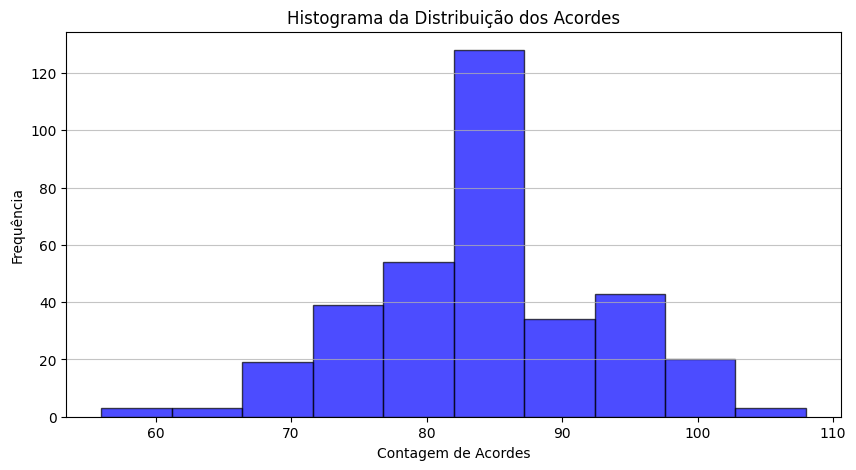

In [28]:
plt.figure(figsize=(10, 5))
plt.hist(combined_df['chord'].value_counts(), bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma da Distribuição dos Acordes')
plt.xlabel('Contagem de Acordes')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [29]:
combined_df = pd.concat([combined_df, extended], ignore_index=True)

### Adições de Ruídos

#### Short audio

In [30]:
noise_path = "chords/noise_audios/short_sounds/"
output_dir = "chords/variation_chord_audio_short_noise/"
os.makedirs(output_dir, exist_ok=True)

In [31]:
short_audio_list = []

In [31]:
def add_noises_short_sounds(file_path, output_dir, noise_path, i, sr=None):
    noise_list = []
    error = 0
    while True:
        try:
            subfolder_choiced = random.choice(os.listdir(noise_path))
            file_subpath = os.path.join(noise_path, subfolder_choiced)
            choosen_noise = random.choice(os.listdir(file_subpath))
            noise_file_path = os.path.join(file_subpath, choosen_noise)
            choosen_noise_name = os.path.splitext(choosen_noise)[0]
            choosen_noise_name = choosen_noise_name.replace(' ','_').lower()
            noise, _ = librosa.load(noise_file_path, sr=sr)
            y, sr = librosa.load(file_path, sr=sr)
            y, _ = librosa.effects.trim(y, top_db=30)
            repated_noise = np.tile(noise, int(np.ceil(len(y) / len(noise))))[:len(y)]

            vol_rate = [.05,.1,.4]

            file_name = os.path.basename(file_path)
            file_name_without_ext = os.path.splitext(file_name)[0]
            for rate in vol_rate:
                y_noise = y + repated_noise * rate
                new_file_path = f'{output_dir}{file_name_without_ext}_v_{rate}_c_{choosen_noise_name}_r_{i}.mp3'
                sf.write(new_file_path, y_noise, sr)

                dict_noise = {
                    'file_path': new_file_path,
                    'y_noise': y_noise
                }

                noise_list.append(dict_noise)
            break
        except Exception as e:
            print(f'Erro ao processar {noise_path}: {e}')
            error += 1
            if error > 20:
                break
    return noise_list

In [ ]:
combined_df.drop_duplicates(inplace = True)
index_path = {fp: idx for idx, fp in combined_df.reset_index().values}

In [ ]:
for file_path in tqdm(combined_df['file_path'], desc='Overall Progress', leave=True):
    for i in range(1):
        new_idx = index_path[file_path]
        new_row = combined_df.iloc[new_idx].copy()
        short_audio = add_noises_short_sounds(file_path, output_dir, noise_path, i, None)
        for noise in short_audio:
            new_row['file_path'] = noise['file_path']
            short_audio_list.append(new_row)

In [33]:
df_short_audio = pd.DataFrame(short_audio_list)
df_short_audio.to_csv('short_audio_data_1.csv', index=False)

In [34]:
folders_to_zip = [
    'chords/variation_chord_audio_short_noise/',
    'short_audio_data_1.csv',               # Dados equilibrados (aumento de dados abaixo do percentil 25)
]

zip_file_name = 'audio_short_noise_bck_1.zip'

In [ ]:
!zip -r {zip_file_name} {" ".join(folders_to_zip)}

In [36]:
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(zip_file_name)
blob.upload_from_filename(zip_file_name)

print(f'Arquivo {zip_file_name} enviado com sucesso para o bucket.')

Arquivo audio_short_noise_bck_1.zip enviado com sucesso para o bucket.


#### World Sounds

In [26]:
noise_path = "chords/noise_audios/world_sounds/"
output_dir = "chords/variation_chord_audio_world_noise/"
os.makedirs(output_dir, exist_ok=True)

In [91]:
world_audio_list = []

In [32]:
def add_noises_world_sounds(file_path, output_dir, noise_path,i, sr=None, white_nose = False, vol_rate = list):
    noise_list = []
    error = 0
    while True:
        try:
            if white_nose:
                choosen_noise = random.choice(os.listdir(noise_path))
                noise_file_path = os.path.join(noise_path, choosen_noise)
            else:
                subfolder_choiced = random.choice(os.listdir(noise_path))
                file_subpath = os.path.join(noise_path, subfolder_choiced)
                choosen_noise = random.choice(os.listdir(file_subpath))
                noise_file_path = os.path.join(file_subpath, choosen_noise)

            choosen_noise_name = os.path.splitext(choosen_noise)[0]
            choosen_noise_name = choosen_noise_name.replace('- ','').replace(',','').replace(' ','_').lower()
            choosen_noise_name = choosen_noise_name.split('_')[:3]
            choosen_noise_name = '_'.join(choosen_noise_name)

            noise, _ = librosa.load(noise_file_path, sr=sr)
            y, sr = librosa.load(file_path, sr=sr)
            y, _ = librosa.effects.trim(y, top_db=30)

            if len(noise) < len(y):
                start_point = random.randint(0, len(y) - len(noise))
                noise = np.tile(noise, int(np.ceil(len(y) / len(noise))))[start_point:start_point + len(y)]
            else:
                start_point = random.randint(0, len(noise) - len(y))
                noise = noise[start_point:start_point + len(y)]

            file_name = os.path.basename(file_path)
            file_name_without_ext = os.path.splitext(file_name)[0]

            for rate in vol_rate:
                y_noise = y + noise * rate
                new_file_path = f'{output_dir}{file_name_without_ext}_v_{rate}_c_{choosen_noise_name}_r_{i}.mp3'
                sf.write(new_file_path, y_noise, sr)

                dict_noise = {
                    'file_path': new_file_path,
                    'y_noise': y_noise
                }

                noise_list.append(dict_noise)
            break
        except Exception as e:
            print(f'Erro ao processar {file_path}: {e}')
            error += 1
            if error > 20:
                break
    return noise_list

In [86]:
continuacao = combined_df[81134:]['file_path'].reset_index(drop=True)
continuacao = pd.DataFrame(continuacao)
continuacao = continuacao.drop_duplicates()

In [87]:
index_path = {fp: idx for idx, fp in continuacao.reset_index().values}

In [ ]:
vol_rate = [.1,.5,1]

for file_path in tqdm(continuacao['file_path'], desc='Overall Progress', leave=True):
    for i in range(1):
        new_idx = index_path[file_path]
        new_row = continuacao.iloc[new_idx].copy()
        short_audio = add_noises_world_sounds(file_path, output_dir, noise_path, i, None, False, vol_rate)
        for noise in short_audio:
            new_row['file_path'] = noise['file_path']
            world_audio_list.append(new_row)

In [93]:
df_world_audio = pd.DataFrame(world_audio_list)
df_world_audio.to_csv('world_audio_data_2.csv', index=False)

In [94]:
folders_to_zip = [
    'chords/variation_chord_audio_world_noise/',
    'world_audio_data_2.csv',               # Dados equilibrados (aumento de dados abaixo do percentil 25)
]

zip_file_name = 'audio_world_noise_bck_2.zip'

In [ ]:
!zip -r {zip_file_name} {" ".join(folders_to_zip)}

In [96]:
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(zip_file_name)
blob.upload_from_filename(zip_file_name)

print(f'Arquivo {zip_file_name} enviado com sucesso para o bucket.')

Arquivo audio_world_noise_bck_2.zip enviado com sucesso para o bucket.


##### Import Final Noise Sounds

In [33]:
bucket_name = 'projeto_musical'
rar_file_name = 'audio_short_noise_bck_1.zip'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [35]:
with zipfile.ZipFile(local_rar_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [70]:
short_noise_1 = pd.read_csv('short_audio_data_1.csv')
short_noise_1 = short_noise_1[['file_path','chord_idx']]
short_noise_1

,file_path,chord_idx
0,chords/variation_chord_audio_short_noise/t_DAD...,30
1,chords/variation_chord_audio_short_noise/t_DAD...,30
2,chords/variation_chord_audio_short_noise/t_DAD...,30
3,chords/variation_chord_audio_short_noise/t_DAD...,30
4,chords/variation_chord_audio_short_noise/t_DAD...,30
...,...,...
532399,chords/variation_chord_audio_short_noise/t_EAD...,372
532400,chords/variation_chord_audio_short_noise/t_EAD...,372
532401,chords/variation_chord_audio_short_noise/t_EAD...,372
532402,chords/variation_chord_audio_short_noise/t_EAD...,372


In [38]:
bucket_name = 'projeto_musical'
rar_file_name = 'audio_world_noise_bck_1.zip'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [39]:
with zipfile.ZipFile(local_rar_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [69]:
world_noise_1 = pd.read_csv('world_audio_data.csv')
world_noise_1 = world_noise_1[['file_path','chord_idx']]
world_noise_1

,file_path,chord_idx
0,chords/variation_chord_audio_world_noise/t_DAD...,30
1,chords/variation_chord_audio_world_noise/t_DAD...,30
2,chords/variation_chord_audio_world_noise/t_DAD...,30
3,chords/variation_chord_audio_world_noise/t_DAD...,30
4,chords/variation_chord_audio_world_noise/t_DAD...,30
...,...,...
243397,chords/variation_chord_audio_world_noise/t_DsG...,369
243398,chords/variation_chord_audio_world_noise/t_DsG...,369
243399,chords/variation_chord_audio_world_noise/t_DsG...,369
243400,chords/variation_chord_audio_world_noise/t_DsG...,369


In [42]:
bucket_name = 'projeto_musical'
rar_file_name = 'audio_world_noise_bck_2.zip'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [43]:
with zipfile.ZipFile(local_rar_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [154]:
audio_data = combined_df[['file_path','chord_idx']]

In [155]:
audio_data['extract_info'] = audio_data['file_path'].str.extract(r'guitar([A-Za-z0-9()]+(?:_[A-Za-z0-9()]+)*?)(fast|slow|strum|\d.*)')[0]
audio_data['extract_info'] = audio_data['extract_info'].str.replace(r'(fast|strum|slow).*$', '', regex=True)

<ipython-input-155-fb698a409c41>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  audio_data['extract_info'] = audio_data['file_path'].str.extract(r'guitar([A-Za-z0-9()]+(?:_[A-Za-z0-9()]+)*?)(fast|slow|strum|\d.*)')[0]
<ipython-input-155-fb698a409c41>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  audio_data['extract_info'] = audio_data['extract_info'].str.replace(r'(fast|strum|slow).*$', '', regex=True)


In [156]:
merge_df = audio_data[['extract_info','chord_idx']].drop_duplicates()

In [ ]:
world_noise_2 = pd.read_csv('world_audio_data_2.csv')
world_noise_2['extract_info'] = world_noise_2['file_path'].str.extract(r'guitar([A-Za-z0-9()]+(?:_[A-Za-z0-9()]+)*?)(fast|slow|strum|\d.*)')[0]
world_noise_2['extract_info'] = world_noise_2['extract_info'].str.replace(r'(fast|strum|slow).*$', '', regex=True)
world_noise_2 = world_noise_2.merge(merge_df[['extract_info', 'chord_idx']], on='extract_info', how='left')
world_noise_2.drop('extract_info', axis=1, inplace=True)
audio_data.drop('extract_info', axis=1, inplace=True)
world_noise_2

In [158]:
world_noise = pd.concat([world_noise_1, world_noise_2])

In [165]:
audio_data = pd.concat([audio_data,short_noise_1], ignore_index=True)
audio_data = pd.concat([audio_data,world_noise], ignore_index=True)

### Export All Files

In [168]:
folders_to_zip = [
    'chords/variation_chord_audio',
    'chords/variation_chord_audio_augmented',
    'chords/variation_chord_audio_extended',
    'chords/variation_chord_audio_short_noise',
    'chords/variation_chord_audio_world_noise',
    "chords/variation_chord_audio_white_noise/"
    'audio_data.csv'
    #'chords/variation_chord_audio_white_noise'
]

zip_file_name = 'audio_data.zip'

In [169]:
!zip -r {zip_file_name} {" ".join(folders_to_zip)}

 (deflated 95%)


In [170]:
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(zip_file_name)
blob.upload_from_filename(zip_file_name)

print(f'Arquivo {zip_file_name} enviado com sucesso para o bucket.')

Arquivo audio_data.zip enviado com sucesso para o bucket.


In [178]:
def add_noises_white_sounds(file_path, output_dir, noise_path,sr=None, white_nose = False, vol_rate = 1):
    noise_list = []
    error = 0
    while True:
        try:
            if white_nose:
                choosen_noise = random.choice(os.listdir(noise_path))
                noise_file_path = os.path.join(noise_path, choosen_noise)
            else:
                subfolder_choiced = random.choice(os.listdir(noise_path))
                file_subpath = os.path.join(noise_path, subfolder_choiced)
                choosen_noise = random.choice(os.listdir(file_subpath))
                noise_file_path = os.path.join(file_subpath, choosen_noise)

            choosen_noise_name = os.path.splitext(choosen_noise)[0]
            choosen_noise_name = choosen_noise_name.replace('- ','').replace(',','').replace(' ','_').lower()
            choosen_noise_name = choosen_noise_name.split('_')[:3]
            choosen_noise_name = '_'.join(choosen_noise_name)

            noise, _ = librosa.load(noise_file_path, sr=sr)
            y, sr = librosa.load(file_path, sr=sr)
            y, _ = librosa.effects.trim(y, top_db=30)

            if len(noise) < len(y):
                start_point = random.randint(0, len(y) - len(noise))
                noise = np.tile(noise, int(np.ceil(len(y) / len(noise))))[start_point:start_point + len(y)]
            else:
                start_point = random.randint(0, len(noise) - len(y))
                noise = noise[start_point:start_point + len(y)]

            file_name = os.path.basename(file_path)
            file_name_without_ext = os.path.splitext(file_name)[0]

            y_noise = y + noise * vol_rate
            new_file_path = f'{output_dir}{file_name_without_ext}_v_{vol_rate}_c_{choosen_noise_name}.mp3'
            sf.write(new_file_path, y_noise, sr)

            dict_noise = {
                'file_path': new_file_path,
                'y_noise': y_noise
            }

            noise_list.append(dict_noise)
            break
        except Exception as e:
            print(f'Erro ao processar {file_path}: {e}')
            error += 1
            if error > 20:
                break
    return noise_list

In [179]:
noise_path = "chords/noise_audios/white_noise_sfx/"
output_dir = "chords/variation_chord_audio_white_noise/"
os.makedirs(output_dir, exist_ok=True)

In [186]:
white_noise_list = []

In [ ]:
vol_rate = [.05,.1,.2,.4]
rate = random.choice(vol_rate)

for file_path in tqdm(audio_data['file_path'], desc='Overall Progress', leave=True):
   new_row = audio_data[audio_data['file_path'] == file_path].iloc[0].copy()
   white_noise = add_noises_white_sounds(file_path, output_dir, noise_path, None, True, rate)
   new_row['file_path'] = white_noise[0]['file_path']
   white_noise_list.append(new_row)

Overall Progress:  20%|██        | 235682/1176060 [11:30:16<47:58:31,  5.44it/s]

In [ ]:
df_white_noise = pd.DataFrame(white_noise_list)
audio_data = pd.concat([audio_data,df_white_noise], ignore_index=True)
audio_data.to_csv('audio_data.csv')